Experimenting with makeing a fits file for the hslp

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import astropy.io.fits as fits
import os
from scipy.io.idl import readsav
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from astropy.modeling import models, fitting
from craftroom import resample
from scipy.interpolate import interp1d


%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [10]:
ecsv_table = Table.read('../combined/gj_674_sed_var_res_v2.ecsv')

/home/david/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:981: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)


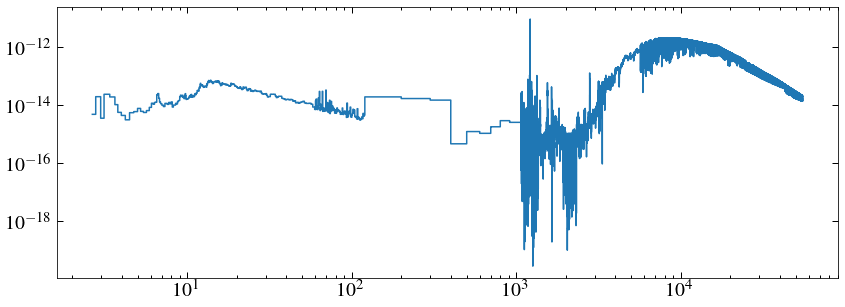

In [11]:
plt.plot(ecsv_table['WAVELENGTH'][ecsv_table['FLUX'] >0], ecsv_table['FLUX'][ecsv_table['FLUX'] >0], drawstyle='steps-mid')
plt.xscale('log')
plt.yscale('log')

What's in a MUSCLES fits file?

In [12]:
hdul = fits.open('../../../stuff/muscles_eg/gj176/hlsp_muscles_multi_multi_gj176_broadband_v22_var-res-sed.fits')

In [13]:
hdul.info()

Filename: ../../../stuff/muscles_eg/gj176/hlsp_muscles_multi_multi_gj176_broadband_v22_var-res-sed.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      53   ()      
  1  SPECTRUM      1 BinTableHDU     59   1196260R x 13C   [D, D, D, D, D, D, I, D, D, J, D, D, D]   
  2  INSTLGND      1 BinTableHDU     32   24R x 5C   [J, 5A, 18A, 6A, 70A]   


In [14]:
hdul[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
TELESCOP= 'MULTI   '                                                            
INSTRUME= 'MULTI   '                                                            
GRATING = 'MULTI   '                                                            
TELESC00= 'MODEL   '                                                            
INSTRU00= 'PHX     '                                                            
GRATIN00= 'NA      '                                                            
TELESC01= 'MODEL   '                                                            
INSTRU01= 'EUV-SCALING'                                                         
GRATIN01= 'NA      '        

Ok that looks easy, I can build that from the instrument file. Oh yeah need to do the Bolometric flux. Check my B flux technique gives the right result...

In [35]:
from astropy.modeling.blackbody import blackbody_lambda
def bb_correct(teff, w_phoenix, f_phoenix):
    """
    addition to intergrated flux to calculate bolometric flux
    """
    bb_flux = blackbody_lambda(w_phoenix, teff)*u.sr
    int_phoenix = np.trapz(f_phoenix, w_phoenix)
    int_bb = np.trapz(bb_flux, w_phoenix)
    scale = int_phoenix/int_bb
    bolometric_flux = (const.sigma_sb * teff ** 4 / np.pi).to(u.erg / (u.cm * u.cm * u.s))
    flux_correct = (bolometric_flux.value * scale.value) - int_phoenix
    return bolometric_flux.value * scale.value,flux_correct

In [16]:
os.listdir('../../../stuff/muscles_eg/gj176/')

['hlsp_muscles_hst_stis_gj176_g230l_v22_component-spec.fits',
 'hlsp_muscles_hst_cos_gj176_g230l_v22_component-spec.fits',
 'hlsp_muscles_model_euv-scaling_gj176_na_v22_component-spec.fits',
 'hlsp_muscles_multi_multi_gj176_broadband_v22_adapt-const-res-sed.fits',
 'hlsp_muscles_cxo_acis_gj176_na_v22_component-spec.fits',
 'hlsp_muscles_hst_cos_gj176_g130m_v22_component-spec.fits',
 'hlsp_muscles_model_apec_gj176_na_v22_component-spec.fits',
 'hlsp_muscles_multi_multi_gj176_broadband_v22_const-res-sed.fits',
 'hlsp_muscles_model_lya-reconstruction_gj176_na_v22_component-spec.fits',
 'hlsp_muscles_hst_stis_gj176_g140m_v22_component-spec.fits',
 'hlsp_muscles_hst_stis_gj176_g430l_v22_component-spec.fits',
 'hlsp_muscles_multi_multi_gj176_broadband_v22_var-res-sed.fits',
 'hlsp_muscles_multi_multi_gj176_broadband_v22_adapt-var-res-sed.fits',
 'hlsp_muscles_hst_cos_gj176_g160m_v22_component-spec.fits',
 'hlsp_muscles_model_phx_gj176_na_v22_component-spec.fits']

In [17]:
hdul2 = fits.open('../../../stuff/muscles_eg/gj176/hlsp_muscles_model_phx_gj176_na_v22_component-spec.fits')

In [18]:
hdul2.info()

Filename: ../../../stuff/muscles_eg/gj176/hlsp_muscles_model_phx_gj176_na_v22_component-spec.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      26   ()      
  1  SPECTRUM      1 BinTableHDU     25   1569128R x 4C   [D, D, D, D]   


In [20]:
pdt = hdul2[1].data

In [28]:
hdul2[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
TELESCOP= 'MODEL   '                                                            
INSTRUME= 'PHX     '                                                            
GRATING = 'NA      '                                                            
TARGNAME= 'GJ176   '                                                            
RA_TARG =    70.73239599999999                                                  
DEC_TARG=            18.958163                                                  
PROPOSID=                13650                                                  
HLSPNAME= 'Measurements of the Ultraviolet Spectral Characteristics of &'       
CONTINUE  'Low-mass Exoplane

In [29]:
scale = hdul2[0].header['NORMFAC']

In [30]:
hdul2.close()

In [31]:
teff = 3416*u.K

In [33]:
data = hdul[1].data

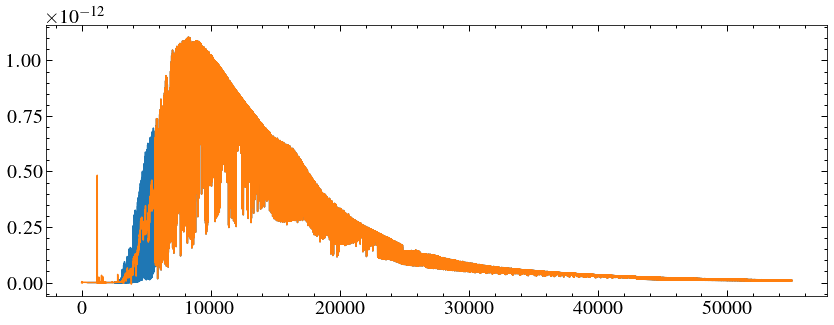

In [34]:
pw, pf = pdt['WAVELENGTH'], pdt['FLUX']*scale
plt.plot(pw, pf)
plt.plot(data['WAVELENGTH'], data['FLUX'])


In [36]:
b_flux, flux_correct =  bb_correct(teff, pdt['WAVELENGTH'], pdt['FLUX']*scale)

In [38]:
b_flux

1.2548162508376985e-08

In [39]:
int_sed = np.trapz(data['FLUX'], data['WAVELENGTH'])

In [43]:
my_b =int_sed+flux_correct

In [42]:
bolo_flux = 1.25681772600649E-08 

In [44]:
print(my_b)
print(bolo_flux)
print(my_b/bolo_flux)

1.25473636980093e-08
1.25681772600649e-08
0.9983439474456066


Close enough

500.0